#Imports & basic config

In [1]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 2.3 MB/s eta 0:00:00


In [2]:
import transformers
print(transformers.__version__)


4.57.2


In [3]:

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q peft bitsandbytes accelerate kagglehub sentence-transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.9/520.9 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 140.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 23.1 MB/s eta 0:00:00


In [4]:

!pip install -U -q bitsandbytes
!pip install -U -q accelerate
!pip install -U -q peft
!pip install -U -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.


In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [2]:
import os, gc, torch

# Disable wandb logging (to avoid side effects & clutter)
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA memory cleared.")


CUDA memory cleared.


In [3]:

# ==========================================
# 1. Install Dependencies
# ==========================================
import os
import json
import torch
import torch.nn as nn
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, util

# Import ViLT specific modules
from transformers import ViltProcessor, ViltForQuestionAnswering, ViltConfig

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


[INFO] Running in WANDB offline mode
Using device: cuda


#VQADataset + training wrapper dataset

In [4]:

# ==========================================
# 2. Data Preparation (Standard)
# ==========================================
DATA_DIR = Path("./vqa_data_medical")

def find_image_file(image_id: str, kaggle_root: Path) -> Path:
    candidates = []
    for ext in (".png", ".jpg", ".jpeg"):
        candidates.extend(kaggle_root.rglob(f"{image_id}{ext}"))
    if not candidates:
        raise FileNotFoundError(f"No image found for {image_id}")
    return candidates[0]

def prepare_data():
    print("Downloading dataset...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json"))
    data_path = candidates[0]

    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].astype(str).apply(lambda x: Path(str(x)).stem)

    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    image_map = {}
    for ext in ["png", "jpg", "jpeg"]:
        for p in kaggle_root.rglob(f"*.{ext}"):
            image_map[p.stem] = p

    return train_df, val_df, test_df, image_map

train_df, val_df, test_df, image_map = prepare_data()

Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.


#Preparing Dataset

In [5]:

# ==========================================
# 3. Build Vocabulary (Answer to ID)
# ==========================================
def build_vocab(df_list):
    all_answers = []
    for df in df_list:
        all_answers.extend(df["answer"].astype(str).tolist())

    counter = Counter(all_answers)
    vocab = sorted(counter.keys())

    answer2idx = {ans: i for i, ans in enumerate(vocab)}
    idx2answer = {i: ans for i, ans in enumerate(vocab)}
    return answer2idx, idx2answer

answer2idx, idx2answer = build_vocab([train_df, val_df, test_df])
NUM_LABELS = len(answer2idx)
print(f"Total Classification Labels: {NUM_LABELS}")

Total Classification Labels: 557


In [6]:

# ==========================================
# 4. Dataset & Processor
# ==========================================
# ViLT Processor handles resizing (default 384x384) and BERT tokenization automatically
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ViLTMedicalDataset(Dataset):
    def __init__(self, df, image_map, answer2idx, processor):
        self.df = df
        self.image_map = image_map
        self.answer2idx = answer2idx
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        question = str(row["question"])
        answer = str(row["answer"])

        # Load Image
        img_path = self.image_map.get(img_id)
        image = Image.open(img_path).convert("RGB")

        # [FIX] Force resize to 384x384 to ensure batch consistency
        # We manually resize to square to prevent aspect-ratio batching errors
        image = image.resize((384, 384))

        # Process Image + Text together
        # [CRITICAL] Pass do_resize=False because we already resized it manually above.
        # This prevents the processor from reverting it to original aspect ratio.
        encoding = self.processor(
            image,
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            do_resize=False  # Disable internal resizing
        )

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze(0)

        # Add Label (Classification Target)
        label_idx = self.answer2idx.get(answer, 0)
        return encoding, torch.tensor(label_idx, dtype=torch.long)

# [FIX] Initialize Datasets (This was missing)
train_ds = ViLTMedicalDataset(train_df, image_map, answer2idx, processor)
val_ds = ViLTMedicalDataset(val_df, image_map, answer2idx, processor)
test_ds = ViLTMedicalDataset(test_df, image_map, answer2idx, processor)

# Batch size can be decent (16 or 32) because ViLT is not huge
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#Model Training

In [9]:
# ==========================================
# 5. Model Setup (Replace Head)
# ==========================================
from transformers import ViltForQuestionAnswering
from peft import LoraConfig, get_peft_model

print("Loading ViLT model...")
model = ViltForQuestionAnswering.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa",
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    id2label=idx2answer,
    label2id=answer2idx
).to(device)


# ==========================================
# 1. Apply LoRA FIRST (before freezing)
# ==========================================
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)


# ==========================================
# 2. Freeze ALL parameters
# ==========================================
for name, param in model.named_parameters():
    param.requires_grad = False


# ==========================================
# 3. Unfreeze LAST Transformer layer
# ==========================================
print("\n🔓 Unfreezing ViLT encoder last layer...")
for name, param in model.vilt.encoder.layer[-1].named_parameters():
    param.requires_grad = True


# ==========================================
# 4. Unfreeze classifier head
# ==========================================
print("🔓 Unfreezing classifier head...")
for name, param in model.classifier.named_parameters():
    param.requires_grad = True


# ==========================================
# 5. LoRA weights MUST remain trainable
# ==========================================
# (because LoRA adds its own trainable A/B matrices)
for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True


# ==========================================
# 6. Show trainable parameters
# ==========================================
model.print_trainable_parameters()


# ==========================================
# 7. Optimizer
# ==========================================
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)
criterion = nn.CrossEntropyLoss()


Loading ViLT model...


Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

ViltForQuestionAnswering LOAD REPORT from: dandelin/vilt-b32-finetuned-vqa
Key                                          | Status     |                                                                                            
---------------------------------------------+------------+--------------------------------------------------------------------------------------------
vilt.embeddings.text_embeddings.position_ids | UNEXPECTED |                                                                                            
classifier.3.weight                          | MISMATCH   | Reinit due to size mismatch ckpt: torch.Size([3129, 1536]) vs model:torch.Size([557, 1536])
classifier.3.bias                            | MISMATCH   | Reinit due to size mismatch ckpt: torch.Size([3129]) vs model:torch.Size([557])            

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISMATCH	:ckpt weights were loaded, but th


🔓 Unfreezing ViLT encoder last layer...
🔓 Unfreezing classifier head...
trainable params: 13,847,386 || all params: 118,354,522 || trainable%: 11.6999


In [10]:

# ==========================================
# 6. Training Loop (Classification) with Early Stopping & Resume
# ==========================================

# Training Configuration
num_epochs = 60
patience = 10
checkpoint_dir = Path("./vilt_checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
resume_file = checkpoint_dir / "latest_checkpoint.pth"
best_model_path = checkpoint_dir / "best_model.pth"

start_epoch = 0
best_val_acc = 0.0
early_stopping_counter = 0
history = []

# [NEW] Resume Logic
if resume_file.exists():
    print(f"🔄 Found checkpoint at {resume_file}. Resuming training...")
    ckpt = torch.load(resume_file, map_location=device)

    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])

    start_epoch = ckpt['epoch'] + 1
    best_val_acc = ckpt['best_val_acc']
    early_stopping_counter = ckpt['early_stopping_counter']
    history = ckpt.get('history', [])

    print(f"   >>> Resuming from Epoch {start_epoch+1}")
    print(f"   >>> Best Val Acc so far: {best_val_acc:.4f}")
else:
    print("🚀 Starting training from scratch...")

print("Starting Training...")

for epoch in range(start_epoch, num_epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0

    for batch, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        logits = outputs.logits

        # Calculate Loss
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Training Accuracy
        preds = logits.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = labels.to(device)

            outputs = model(**batch)
            logits = outputs.logits

            # Loss
            loss = criterion(logits, labels)
            total_val_loss += loss.item()

            # Accuracy
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | Val Loss={avg_val_loss:.4f} Acc={val_acc:.4f}")

    # Store history
    history.append({
        "epoch": epoch+1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    # --- Early Stopping & Save Best ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f">>> 🌟 New Best Model Saved! (Acc: {best_val_acc:.4f})")
    else:
        early_stopping_counter += 1
        print(f"   >>> No improvement. Counter: {early_stopping_counter}/{patience}")

    # [NEW] Save Latest Checkpoint (For Resuming)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'early_stopping_counter': early_stopping_counter,
        'history': history
    }, resume_file)

    if early_stopping_counter >= patience:
        print("🛑 Early stopping triggered.")
        break

print("Training finished.")

🚀 Starting training from scratch...
Starting Training...


Epoch 1 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: Train Loss=4.4660 Acc=0.1963 | Val Loss=3.9840 Acc=0.1956
>>> 🌟 New Best Model Saved! (Acc: 0.1956)


Epoch 2 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2: Train Loss=3.3845 Acc=0.2547 | Val Loss=3.8754 Acc=0.2311
>>> 🌟 New Best Model Saved! (Acc: 0.2311)


Epoch 3 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3: Train Loss=3.0080 Acc=0.3582 | Val Loss=3.7691 Acc=0.2400
>>> 🌟 New Best Model Saved! (Acc: 0.2400)


Epoch 4 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4: Train Loss=2.5977 Acc=0.5200 | Val Loss=3.6974 Acc=0.2889
>>> 🌟 New Best Model Saved! (Acc: 0.2889)


Epoch 5 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5: Train Loss=2.1575 Acc=0.6741 | Val Loss=3.6197 Acc=0.3422
>>> 🌟 New Best Model Saved! (Acc: 0.3422)


Epoch 6 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6: Train Loss=1.7023 Acc=0.7976 | Val Loss=3.6988 Acc=0.3333
   >>> No improvement. Counter: 1/10


Epoch 7 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7: Train Loss=1.3360 Acc=0.8810 | Val Loss=3.8115 Acc=0.3511
>>> 🌟 New Best Model Saved! (Acc: 0.3511)


Epoch 8 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8: Train Loss=1.0528 Acc=0.9255 | Val Loss=3.6864 Acc=0.3689
>>> 🌟 New Best Model Saved! (Acc: 0.3689)


Epoch 9 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.7862 Acc=0.9616 | Val Loss=3.7225 Acc=0.3689
   >>> No improvement. Counter: 1/10


Epoch 10 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5653 Acc=0.9778 | Val Loss=3.6687 Acc=0.3911
>>> 🌟 New Best Model Saved! (Acc: 0.3911)


Epoch 11 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.4047 Acc=0.9844 | Val Loss=3.6448 Acc=0.4044
>>> 🌟 New Best Model Saved! (Acc: 0.4044)


Epoch 12 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.2862 Acc=0.9922 | Val Loss=3.6787 Acc=0.4089
>>> 🌟 New Best Model Saved! (Acc: 0.4089)


Epoch 13 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.2060 Acc=0.9950 | Val Loss=3.6605 Acc=0.4267
>>> 🌟 New Best Model Saved! (Acc: 0.4267)


Epoch 14 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.1486 Acc=0.9967 | Val Loss=3.6443 Acc=0.4222
   >>> No improvement. Counter: 1/10


Epoch 15 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.1103 Acc=0.9972 | Val Loss=3.6699 Acc=0.4356
>>> 🌟 New Best Model Saved! (Acc: 0.4356)


Epoch 16 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.0844 Acc=0.9983 | Val Loss=3.6719 Acc=0.4267
   >>> No improvement. Counter: 1/10


Epoch 17 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.0661 Acc=0.9994 | Val Loss=3.6893 Acc=0.4222
   >>> No improvement. Counter: 2/10


Epoch 18 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.0537 Acc=0.9983 | Val Loss=3.7020 Acc=0.4178
   >>> No improvement. Counter: 3/10


Epoch 19 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.0446 Acc=0.9983 | Val Loss=3.7029 Acc=0.4400
>>> 🌟 New Best Model Saved! (Acc: 0.4400)


Epoch 20 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.0374 Acc=0.9983 | Val Loss=3.7235 Acc=0.4311
   >>> No improvement. Counter: 1/10


Epoch 21 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.0318 Acc=0.9989 | Val Loss=3.7302 Acc=0.4267
   >>> No improvement. Counter: 2/10


Epoch 22 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.0282 Acc=0.9983 | Val Loss=3.7550 Acc=0.4267
   >>> No improvement. Counter: 3/10


Epoch 23 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.0242 Acc=0.9994 | Val Loss=3.7602 Acc=0.4356
   >>> No improvement. Counter: 4/10


Epoch 24 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.0212 Acc=0.9989 | Val Loss=3.7760 Acc=0.4311
   >>> No improvement. Counter: 5/10


Epoch 25 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.0193 Acc=0.9989 | Val Loss=3.7872 Acc=0.4311
   >>> No improvement. Counter: 6/10


Epoch 26 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.0171 Acc=0.9983 | Val Loss=3.7933 Acc=0.4356
   >>> No improvement. Counter: 7/10


Epoch 27 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.0170 Acc=0.9978 | Val Loss=3.8120 Acc=0.4267
   >>> No improvement. Counter: 8/10


Epoch 28 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.0137 Acc=0.9989 | Val Loss=3.8229 Acc=0.4356
   >>> No improvement. Counter: 9/10


Epoch 29 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.0129 Acc=0.9989 | Val Loss=3.8409 Acc=0.4222
   >>> No improvement. Counter: 10/10
🛑 Early stopping triggered.
Training finished.


#Evaluation

In [11]:

# ==========================================
# 7. Evaluation & Metric Generation
# ==========================================
print("\nRunning Final Evaluation...")

# Reload Best Model
if os.path.exists(best_model_path):
    print("Loading best model for evaluation...")
    model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for batch, labels in tqdm(test_loader, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = labels.to(device)

        outputs = model(**batch)
        logits = outputs.logits

        # Classification prediction: argmax
        preds = logits.argmax(dim=1)

        for p_idx, g_idx in zip(preds, labels):
            pred_text = idx2answer[p_idx.item()]
            gt_text = idx2answer[g_idx.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            # SBERT Similarity calculation
            p_clean = pred_text.replace("_", " ").lower().strip()
            g_clean = gt_text.replace("_", " ").lower().strip()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

# Create DataFrame
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "similarity": similarities
})

# Normalize for correct check (ignore case)
df_results['is_correct'] = df_results.apply(
    lambda x: 1 if x['gt_answer'].lower().strip() == x['pred_answer'].lower().strip() else 0, axis=1
)

final_acc = df_results['is_correct'].mean()
avg_sim = df_results['similarity'].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)


Running Final Evaluation...
Loading best model for evaluation...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Testing:   0%|          | 0/225 [00:00<?, ?it/s]

Final Test Accuracy: 0.5689
Final SBERT Similarity: 0.6987


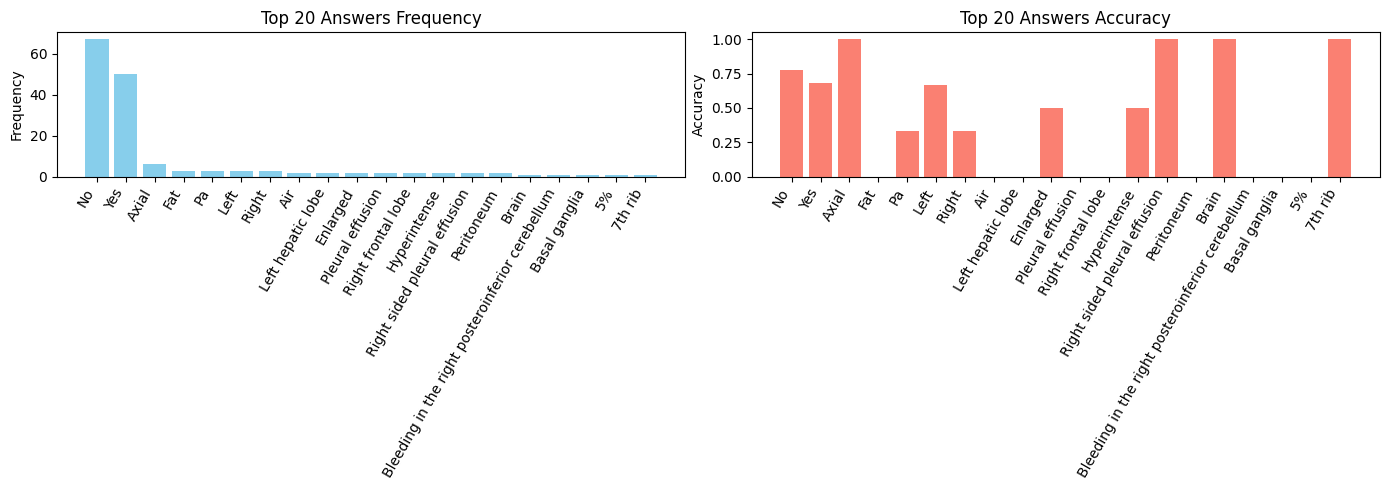

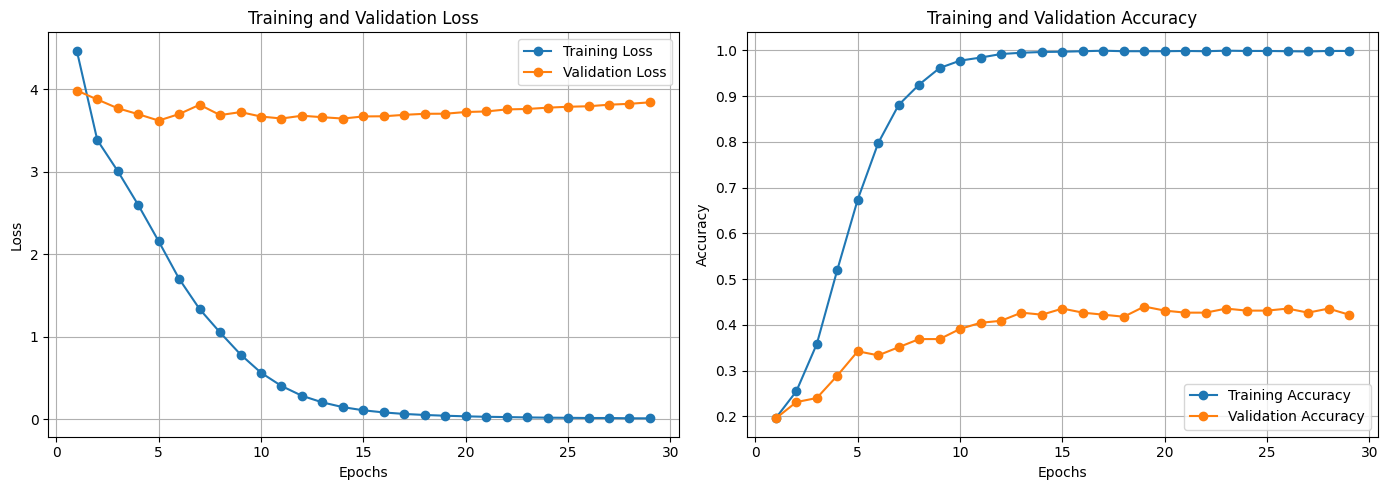

In [12]:

# ==========================================
# 8. Visualization (Charts & Images)
# ==========================================
# 8.1 Statistics Plot
# Normalize ground truth for grouping (Capitalize)
df_results['gt_display'] = df_results['gt_answer'].apply(lambda x: x.lower().strip().capitalize())

stats = (
    df_results
    .groupby("gt_display")["is_correct"]
    .agg(["count", "mean"])
    .rename(columns={"count": "freq", "mean": "acc"})
    .sort_values("freq", ascending=False)
)

TOP_N = 20
top_stats = stats.head(TOP_N)

plt.figure(figsize=(14, 5))

# Frequency Plot
plt.subplot(1, 2, 1)
plt.bar(range(len(top_stats)), top_stats["freq"], color='skyblue')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Answers Frequency")

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.bar(range(len(top_stats)), top_stats["acc"], color='salmon')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.title(f"Top {TOP_N} Answers Accuracy")

plt.tight_layout()
plt.show()

# 8.2 Training History Plot
if history:
    epochs = [x['epoch'] for x in history]
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Generating Qualitative Examples...


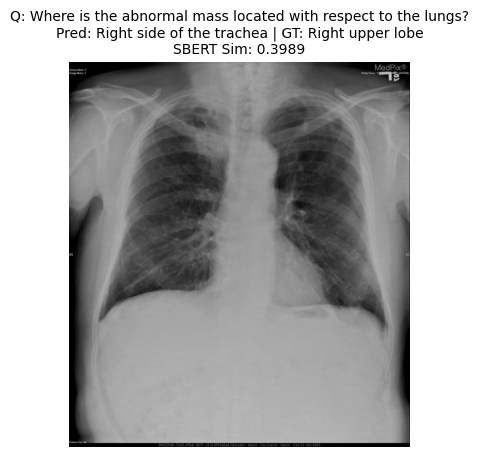

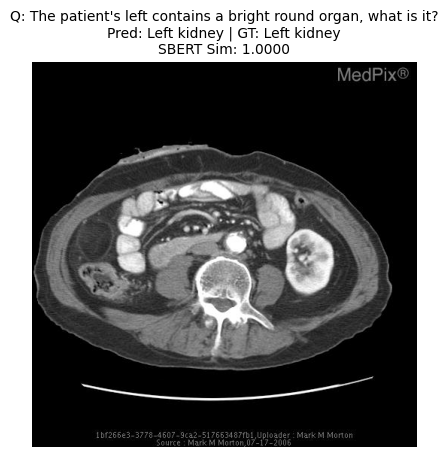

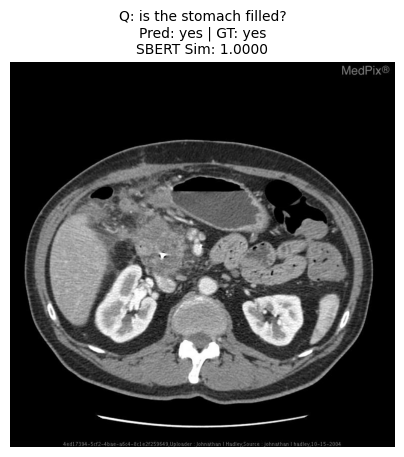

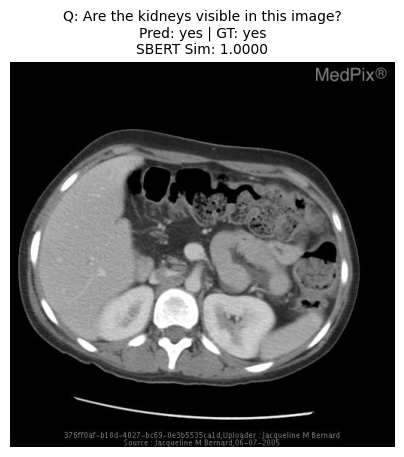

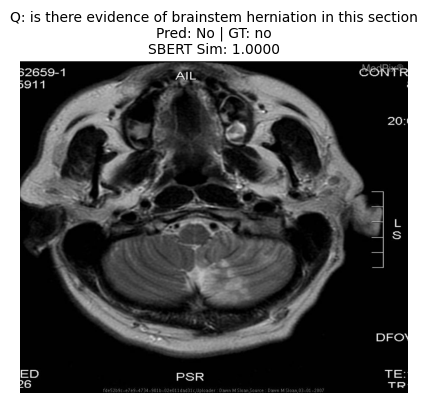

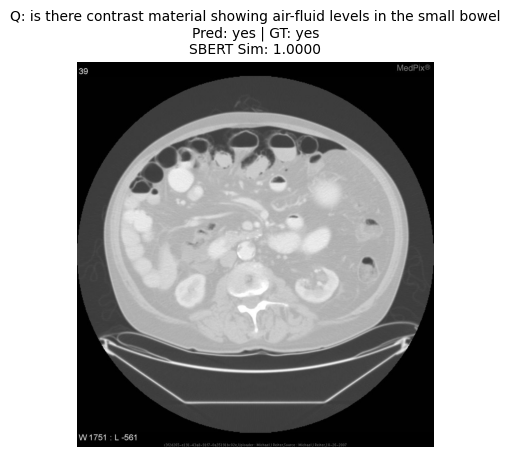

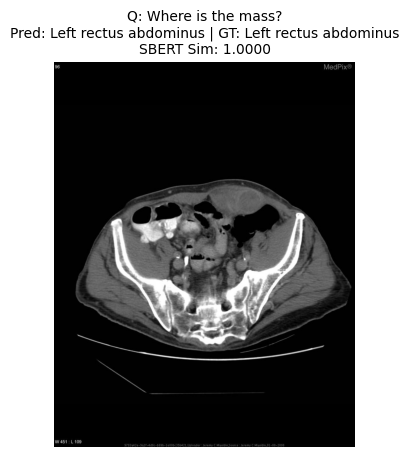

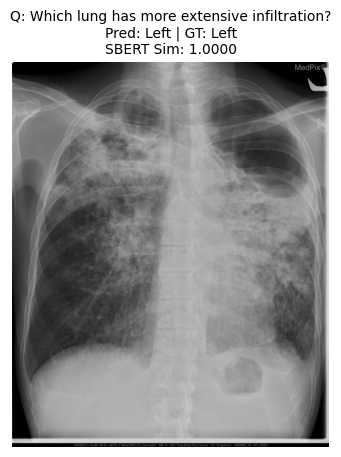

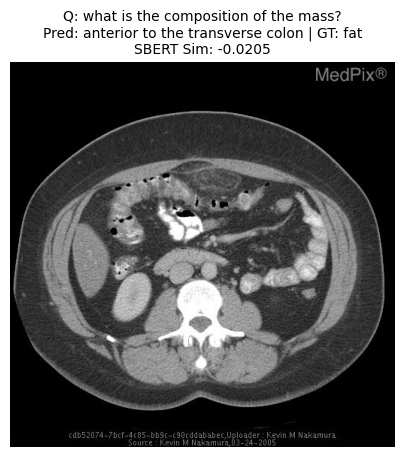

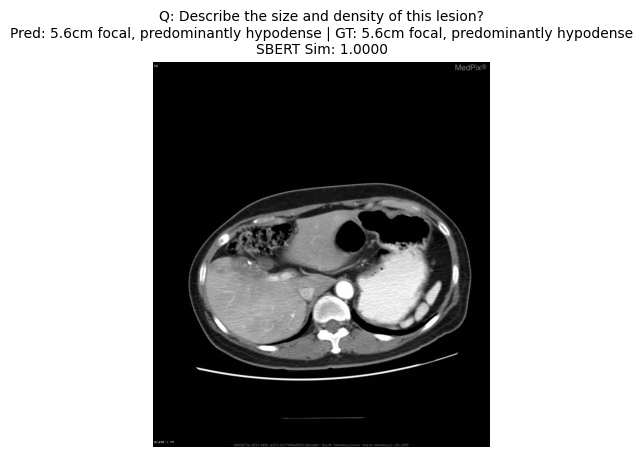

In [13]:

# 8.3 Qualitative Results (Images & Predictions)
print("\nGenerating Qualitative Examples...")

count = 0
max_examples = 10

# We iterate through the raw data in test_dataset (which contains paths)
# and pair it with our prediction results in df_results.
raw_test_data = test_ds.df

for i in range(len(raw_test_data)):
    if count >= max_examples:
        break

    # Check bounds
    if i >= len(df_results):
        break

    row_data = raw_test_data.iloc[i]
    img_id = row_data["image_id"]

    # Construct path
    img_path = image_map.get(img_id)
    if img_path is None: continue

    question = row_data["question"]

    # Get results
    res_row = df_results.iloc[i]
    gt_answer = res_row['gt_answer']
    pred_answer = res_row['pred_answer']
    similarity = res_row['similarity']

    try:
        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Q: {question}\nPred: {pred_answer} | GT: {gt_answer}\nSBERT Sim: {similarity:.4f}", fontsize=10)
        plt.axis('off')
        plt.show()

        count += 1
    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")